In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import optuna 
import pandas as pd
import pickle
import re
import seaborn as sns
import sys
sys.path.append('../ds_core_sanpier/ds_core_sanpi/')
from catboost import CatBoostRegressor
from classifier_utils import classification_metrics
from datetime import timedelta
from exploratory_data_analyzer import EDA_Preprocessor
from itertools import product
from lightgbm import LGBMClassifier, LGBMRegressor
from regressor_utils import Regressor, regression_metrics
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor, StackingRegressor, VotingRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

# Load

In [3]:
# training data
df_train = pd.read_csv("./data/train.csv", sep=",")
df_train['date'] = pd.to_datetime(df_train['date'])
print(df_train.shape)
df_train.tail(1)

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
3000887,3000887,2017-08-15,9,SEAFOOD,16.0,0


In [4]:
# test data
df_test = pd.read_csv("./data/test.csv", sep=",")
df_test['date'] = pd.to_datetime(df_test['date'])
print(df_test.shape)
df_test.head(1)

(28512, 5)


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0


In [5]:
# store data
df_store = pd.read_csv("./data/stores.csv", sep=",")
print(df_store.shape)
df_store.head(1)

(54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13


In [6]:
# transactions data
df_transactions = pd.read_csv("./data/transactions.csv", sep=",")
df_transactions['date'] = pd.to_datetime(df_transactions['date'])
print(df_transactions.shape)
df_transactions.head(1)

(83488, 3)


,date,store_nbr,transactions
0,2013-01-01,25,770


In [7]:
# oil data
df_oil = pd.read_csv("./data/oil.csv", sep=",")
df_oil['date'] = pd.to_datetime(df_oil['date'])
print(df_oil.shape)
df_oil.head(1)

(1218, 2)


,date,dcoilwtico
0,2013-01-01,NaN


In [8]:
# holiday data
df_holiday = pd.read_csv("./data/holidays_events.csv", sep=",")
df_holiday['date'] = pd.to_datetime(df_holiday['date'])
print(df_holiday.shape)
df_holiday.head(1)

(350, 6)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False


# First Glance

## Train Data

In [9]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [10]:
# index is same as id
print(all(df_train.id == df_train.index))
df_train.drop(columns=["id"], inplace=True)

True


In [11]:
# info
df_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   date         3000888 non-null  datetime64[ns]
 1   store_nbr    3000888 non-null  int64         
 2   family       3000888 non-null  object        
 3   sales        3000888 non-null  float64       
 4   onpromotion  3000888 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 114.5+ MB


In [12]:
# store 
df_train.store_nbr.nunique(), df_train.store_nbr.unique()

(54,
 array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
        25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
        40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
         7,  8,  9], dtype=int64))

In [13]:
# family
df_train.family.nunique(), df_train.family.unique()

(33,
 array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
        'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
        'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
        'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
        'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
        'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
        'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
        'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
        'SEAFOOD'], dtype=object))

In [14]:
# onpromotion
df_train.onpromotion.value_counts()[:5], df_train.onpromotion.max()

(onpromotion
 0    2389559
 1     174551
 2      79386
 3      45862
 4      31659
 Name: count, dtype: int64,
 741)

In [15]:
# min / max date
df_train.date.min(), df_train.date.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [16]:
# days
df_train.date.nunique(), 365*4 + 30*7 + 15

(1684, 1685)

In [17]:
# number of stores * number of product families * number of days
df_train.shape, df_train.store_nbr.nunique()*df_train.family.nunique()*df_train.date.nunique()

((3000888, 5), 3000888)

In [18]:
# NOTE: training data is missing some days: dates where all stores were closed?
len(pd.date_range(start='2013-01-01', end='2017-08-15'))

1688

In [19]:
# create a df for full date range
date_range = pd.date_range(start='2013-01-01', end='2017-08-15')
stores = df_train['store_nbr'].unique()
families = df_train['family'].unique()
all_dates = pd.MultiIndex.from_product([date_range, stores, families], names=['date', 'store_nbr', 'family'])
df_complete = pd.DataFrame(index=all_dates).reset_index()
print(df_complete.shape)
df_complete.head(1)

(3008016, 3)


,date,store_nbr,family
0,2013-01-01,1,AUTOMOTIVE


In [20]:
# complete the train data
print(df_train.shape)
df_train = df_complete.merge(df_train, on=['date', 'store_nbr', 'family'], how="left")
df_train["sales"] = df_train["sales"].fillna(0)
df_train["onpromotion"] = df_train["onpromotion"].fillna(0)
print(df_train.shape)

(3000888, 5)
(3008016, 5)


In [21]:
# target: sales
print(df_train.sales.min(), df_train.sales.max())
df_train.sales.value_counts()[:5]

0.0 124717.0


sales
0.0    946258
1.0    115291
2.0     85959
3.0     68575
4.0     57846
5.0     49853
Name: count, dtype: int64

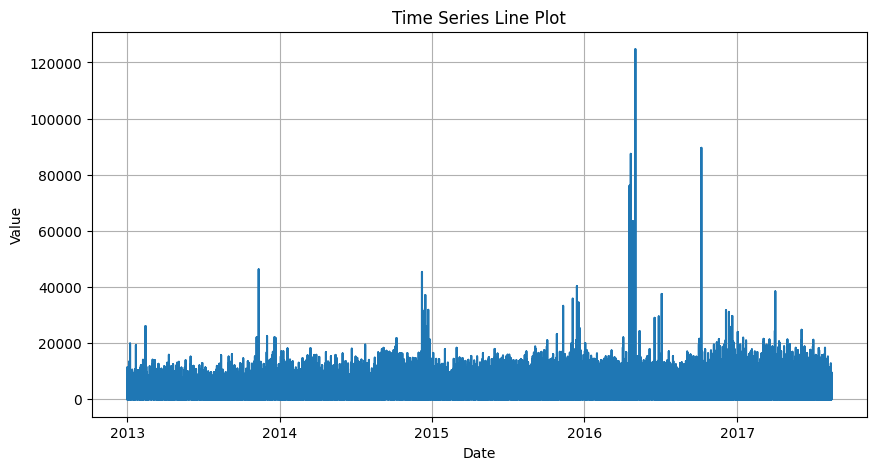

In [22]:
# sales
plt.figure(figsize=(10, 5))
plt.plot(df_train['date'], df_train['sales'])
plt.title('Time Series Line Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## Test Data

In [23]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [24]:
# id vs index
all((df_test.id - 3000888) == df_test.index)
df_test.drop(columns=["id"], inplace=True)

In [25]:
# min / max date
df_test.date.min(), df_test.date.max(), df_test.date.nunique()

(Timestamp('2017-08-16 00:00:00'), Timestamp('2017-08-31 00:00:00'), 16)

In [26]:
# number of stores * number of product families * number of days
df_test.shape, df_test.store_nbr.nunique()*df_test.family.nunique()*df_test.date.nunique(), \
df_train.store_nbr.nunique()*df_train.family.nunique()*df_test.date.nunique() 

((28512, 4), 28512, 28512)

## Store Data

In [27]:
df_store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [28]:
# city & state
print(len(df_store), df_store.city.nunique(), df_store.state.nunique())
df_store.city.value_counts()[:5], df_store.state.value_counts()[:5]

54 22 16


(city
 Quito            18
 Guayaquil         8
 Cuenca            3
 Santo Domingo     3
 Manta             2
 Name: count, dtype: int64,
 state
 Pichincha                         19
 Guayas                            11
 Santo Domingo de los Tsachilas     3
 Azuay                              3
 Manabi                             3
 Name: count, dtype: int64)

In [29]:
# type
print(df_store.type.nunique())
df_store.type.value_counts()[:5]

5


type
D    18
C    15
A     9
B     8
E     4
Name: count, dtype: int64

In [30]:
# cluster
print(df_store.cluster.nunique())
df_store.cluster.value_counts()[:5]

17


cluster
3     7
6     6
10    6
15    5
13    4
Name: count, dtype: int64

In [31]:
# NOTE: state and city doesn't provide any more granular info than store number
df_store[["state", "city", "store_nbr"]].value_counts().sort_index()

state                           city           store_nbr
Azuay                           Cuenca         37           1
                                               39           1
                                               42           1
Bolivar                         Guaranda       19           1
Chimborazo                      Riobamba       14           1
Cotopaxi                        Latacunga      12           1
                                               13           1
El Oro                          Machala        40           1
                                               41           1
Esmeraldas                      Esmeraldas     43           1
Guayas                          Daule          27           1
                                Guayaquil      24           1
                                               26           1
                                               28           1
                                               29           1
             

In [32]:
# NOTE: type and cluster doesn't provide any more granular info than store number
df_store[["type", "cluster", "store_nbr"]].value_counts().sort_index()

type  cluster  store_nbr
A     5        44           1
      11       45           1
               49           1
               52           1
      14       46           1
               47           1
               48           1
               50           1
      17       51           1
B     6        9            1
               11           1
               20           1
               21           1
               34           1
               39           1
      10       31           1
      16       18           1
C     3        16           1
               30           1
               32           1
               33           1
               35           1
               40           1
               54           1
      7        14           1
               22           1
      12       17           1
      15       10           1
               12           1
               13           1
               15           1
               19           1
D     1        

## Transactions Data

In [33]:
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [34]:
# info
df_transactions.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [35]:
# min / max date
# NOTE: no date & info for the test data!?
df_transactions.date.min(), df_transactions.date.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [36]:
# number of days and stores
df_transactions.shape, df_transactions.date.nunique(), df_transactions.store_nbr.nunique()

((83488, 3), 1682, 54)

In [37]:
# NOTE: some of the days and some stores are missing, we can assume no transaction happening for those days (maybe closed!)
df_train.date.nunique() * df_train.store_nbr.nunique()

91152

In [38]:
# create a df for full date range
date_range = pd.date_range(start='2013-01-01', end='2017-08-15')
stores = df_train['store_nbr'].unique()
all_dates = pd.MultiIndex.from_product([date_range, stores], names=['date', 'store_nbr'])
df_complete = pd.DataFrame(index=all_dates).reset_index()
print(df_complete.shape)
df_complete.head(1)

(91152, 2)


,date,store_nbr
0,2013-01-01,1


In [39]:
# complete the transactions data
print(df_transactions.shape)
df_transactions = df_complete.merge(df_transactions, on=['date', 'store_nbr'], how="left")
df_transactions["transactions"] = df_transactions["transactions"].fillna(0)
print(df_transactions.shape)

(83488, 3)
(91152, 3)


In [40]:
# check if transactions can be generatable from train data
# NOTE: answer is no!
df_train_sales = df_train.groupby(["date", "store_nbr"]).agg({"sales": "sum"}).reset_index()
df_train_sales = df_train_sales.merge(df_transactions, on=["date", "store_nbr"], how="left")
df_train_sales[150:155]

,date,store_nbr,sales,transactions
150,2013-01-03,43,5206.77900,1334.0
151,2013-01-03,44,20447.05700,3618.0
152,2013-01-03,45,17377.98097,3314.0
153,2013-01-03,46,15751.35500,3438.0
154,2013-01-03,47,18340.20500,3660.0


In [41]:
# info
df_transactions.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91152 entries, 0 to 91151
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          91152 non-null  datetime64[ns]
 1   store_nbr     91152 non-null  int64         
 2   transactions  91152 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.1 MB


## Oil Data

In [42]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [43]:
# info
df_oil.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [44]:
# min / max date
df_oil.date.min(), df_oil.date.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-31 00:00:00'))

In [45]:
# NOTE: some days are missing, some price values are also missing
# NOTE: assume the price is not changing for those days
# create a df for full date range
date_range = pd.date_range(start='2013-01-01', end='2017-08-31')
all_dates = pd.MultiIndex.from_product([date_range], names=['date'])
df_complete = pd.DataFrame(index=all_dates).reset_index()
print(df_complete.shape)
df_complete.head(1)

(1704, 1)


,date
0,2013-01-01


In [46]:
# complete the oil price data
print(df_oil.shape)
df_oil = df_complete.merge(df_oil, on=['date'], how="left")
df_oil["dcoilwtico"] = df_oil["dcoilwtico"].ffill().bfill()
print(df_oil.shape)

(1218, 2)
(1704, 2)


In [47]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12


## Holiday Data

In [48]:
df_holiday.tail()

,date,type,locale,locale_name,description,transferred
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [49]:
# info
df_holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [50]:
# drop unnecessary columns
df_holiday.drop(columns=["description", "locale_name"], inplace=True)
df_holiday.head(1)

,date,type,locale,transferred
0,2012-03-02,Holiday,Local,False


In [51]:
# transferred
df_holiday.transferred.value_counts()

transferred
False    338
True      12
Name: count, dtype: int64

In [52]:
# NOTE: let's get rid of transferred holidays, which become normal days
df_holiday = df_holiday[~df_holiday.transferred].reset_index(drop=True)
df_holiday.drop(columns=["transferred"], inplace=True)
print(df_holiday.shape)
df_holiday.type.value_counts()

(338, 3)


type
Holiday       209
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64

In [53]:
# type
df_holiday.type.value_counts()

type
Holiday       209
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64

In [54]:
# locale
df_holiday.locale.value_counts()

locale
National    166
Local       148
Regional     24
Name: count, dtype: int64

In [55]:
# create a df for full date range
date_range = pd.date_range(start='2013-01-01', end='2017-08-31')
all_dates = pd.MultiIndex.from_product([date_range], names=['date'])
df_complete = pd.DataFrame(index=all_dates).reset_index()
print(df_complete.shape)
df_complete.head(1)

(1704, 1)


,date
0,2013-01-01


In [56]:
# NOTE: repetetive holidays
df_holiday.date.nunique(), df_holiday.shape

(300, (338, 3))

In [57]:
# keep last column
df_holiday.drop_duplicates(subset=["date"], keep="last", inplace=True)
df_holiday.shape

(300, 3)

In [58]:
# complete the holidays data
print(df_holiday.shape)
df_holiday = df_complete.merge(df_holiday, on=['date'], how="left")
df_holiday["type"] = df_holiday["type"].fillna("Else")
df_holiday["locale"] = df_holiday["locale"].fillna("Else")
print(df_holiday.shape)
df_holiday.head(1)

(300, 3)
(1704, 3)


,date,type,locale
0,2013-01-01,Holiday,National


# Engineering Features

In [59]:
# copy
df_all = pd.concat([df_train, df_test])
df_all.shape

(3036528, 5)

In [60]:
# convert dates
df_all['date'] = pd.to_datetime(df_all['date'])
df_transactions['date'] = pd.to_datetime(df_transactions['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_holiday['date'] = pd.to_datetime(df_holiday['date'])

In [61]:
"""
# merge store data directly
df_all = df_all.merge(df_store, on="store_nbr", how="left")
print(df_all.shape)
df_all.head()
"""

'\n# merge store data directly\ndf_all = df_all.merge(df_store, on="store_nbr", how="left")\nprint(df_all.shape)\ndf_all.head()\n'

In [62]:
# NOTE: comments
#   1. historical change: sales 2013 to 2017
#   2. sales vs time (month / year)
#   3. sales vs stores
#   4. sales vs family
#   5. sales vs oil price
#   6. sales vs holiday (before / after)

## Date

In [63]:
def historical_statistics(df_stat, df_orig, groupby_cols, target_col, drop=True):
    # set dates
    if 'month' not in df_stat.columns:
        df_stat['month'] = df_stat['date'].dt.month
        df_stat['year'] = df_stat['date'].dt.year

    # monthly and yearly statistics of target column
    for i in ["month", "year"]:
        stats = df_stat.groupby(groupby_cols + [i])[target_col].agg(['mean', 'min', 'max', 'std']).reset_index()
        stats.columns = groupby_cols + [i, f'{i}ly_mean_{target_col}', f'{i}ly_min_{target_col}', f'{i}ly_max_{target_col}', f'{i}ly_std_{target_col}']
        df_orig = df_orig.merge(stats, on=groupby_cols + [i], how='left')
    if drop:
        df_orig.drop(columns=[target_col, "month", "year"], inplace=True)
    return df_orig

def date_engineering(df, target, max_stat_year, stat_cols):
    # time of the year
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

    # cyclic encoding of months: capture the continuity over time (e.g., the similarity between december and january)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # seasonal Features
    df['is_spring'] = df['month'].isin([3, 4, 5]).astype(int)
    df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
    df['is_fall'] = df['month'].isin([9, 10, 11]).astype(int)
    df['is_winter'] = df['month'].isin([12, 1, 2]).astype(int)

    # target statistics
    train_df = df[df['year'] < max_stat_year]
    df = historical_statistics(train_df, df, stat_cols, target, drop=False)
    
    df = pd.get_dummies(df, columns=['year', 'month', 'dayofweek'], prefix=['year', 'month', 'dayofweek'])
    return df

## Timeseries

In [68]:
def timeseries_engineering(group, target, shifters=[], diff=True):
    # rolling window
    for offset in [3, 5, 7, 14, 31]:
        for stat in ['mean', 'std']:
            if len(shifters) > 0:
                for shift_i in shifters:
                    group[f'rolling_{stat}_{offset}_{target}_shifted_{shift_i}'] = group[target].transform(lambda x: x.shift(shift_i).rolling(window=offset).agg(stat))
            else:
                group[f'rolling_{stat}_{offset}_{target}'] = group[target].transform(lambda x: x.rolling(window=offset).agg(stat))  
        if diff:            
            if len(shifters) > 0:
                for i, shift_i in enumerate(sorted(shifters)[:-1]):
                    group[f'diff_rolling_mean_{offset}_{target}_{shift_i}_vs_{sorted(shifters)[i+1]}'] = group[f'rolling_{stat}_{offset}_{target}_shifted_{shift_i}'] - group[f'rolling_{stat}_{offset}_{target}_shifted_{sorted(shifters)[i+1]}']
            else:
                group[f'diff_rolling_mean_{offset}_{target}'] = group[target] - group[f'rolling_mean_{offset}_{target}']
        else:
            if len(shifters) > 0:
                for shift_i in sorted(shifters)[:-1]:
                    group[f'ratio_rolling_mean_{offset}_{target}_{shift_i}_vs_{sorted(shifters)[i+1]}'] = group[f'rolling_{stat}_{offset}_{target}_shifted_{shift_i}'] / group[f'rolling_{stat}_{offset}_{target}_shifted_{sorted(shifters)[i+1]}']
            else:
                group[f'ratio_rolling_mean_{offset}_{target}'] = group[target] / group[f'rolling_mean_{offset}_{target}']

    # exponential weighted
    for alpha in [0.3, 0.5, 0.8]:
        if len(shifters) > 0:
            for shift_i in shifters:
                group[f'ewm_alpha_{alpha}_{target}_shifted_{shift_i}'] = group[target].transform(lambda x: x.shift(shift_i).ewm(alpha=alpha).mean())
        else:
            group[f'ewm_alpha_{alpha}_{target}'] = group[target].transform(lambda x: x.ewm(alpha=alpha).mean()) 
    
    # seasonal decompose
    for offset in [31]:
        if len(shifters) > 0:
            for shift_i in shifters:
                sd_year = seasonal_decompose(group[target].shift(shift_i).fillna(0), model='additive', period=offset)
                group[f'trend_{offset}_{target}_shifted_{shift_i}'], group[f'seasonal_{offset}_{target}_shifted_{shift_i}'], group[f'resid_{offset}_{target}_shifted_{shift_i}'] = sd_year.trend, sd_year.seasonal, sd_year.resid
        else:
            sd_result = seasonal_decompose(group[target], model='additive', period=offset)
            group[f'trend_{offset}_{target}'], group[f'seasonal_{offset}_{target}'], group[f'resid_{offset}_{target}'] = sd_result.trend, sd_result.seasonal, sd_result.resid
    
    # fourier transform
    if len(shifters) > 0:
        for shift_i in shifters:
            fft_result = np.fft.fft(group[target].shift(shift_i).fillna(0))
            for i in range(1, 4):
                group[f'fft_real_{i}_{target}_shifted_{shift_i}'] = np.real(fft_result[i])
                group[f'fft_imag_{i}_{target}_shifted_{shift_i}'] = np.imag(fft_result[i])
    else:
        fft_result = np.fft.fft(group[target])
        for i in range(1, 4):
            group[f'fft_real_{i}_{target}'] = np.real(fft_result[i])
            group[f'fft_imag_{i}_{target}'] = np.imag(fft_result[i])

    # fill missing columns
    group = group.transform(lambda x: x.interpolate(method='bfill').ffill()).fillna(method='bfill')
    return group

## Oil

In [65]:
# original oil data
print(df_oil.shape)
df_oil.head(1)

(1704, 2)


,date,dcoilwtico
0,2013-01-01,93.14


In [69]:
# timeseries engineer of oil data
df_oil = timeseries_engineering(df_oil, "dcoilwtico", [], False)
print(df_oil.shape)
df_oil.head(1)

(1704, 29)


,date,dcoilwtico,rolling_mean_3_dcoilwtico,rolling_std_3_dcoilwtico,ratio_rolling_mean_3_dcoilwtico,rolling_mean_5_dcoilwtico,rolling_std_5_dcoilwtico,ratio_rolling_mean_5_dcoilwtico,rolling_mean_7_dcoilwtico,rolling_std_7_dcoilwtico,ratio_rolling_mean_7_dcoilwtico,rolling_mean_14_dcoilwtico,rolling_std_14_dcoilwtico,ratio_rolling_mean_14_dcoilwtico,rolling_mean_31_dcoilwtico,rolling_std_31_dcoilwtico,ratio_rolling_mean_31_dcoilwtico,ewm_alpha_0.3_dcoilwtico,ewm_alpha_0.5_dcoilwtico,ewm_alpha_0.8_dcoilwtico,trend_31_dcoilwtico,seasonal_31_dcoilwtico,resid_31_dcoilwtico,fft_real_1_dcoilwtico,fft_imag_1_dcoilwtico,fft_real_2_dcoilwtico,fft_imag_2_dcoilwtico,fft_real_3_dcoilwtico,fft_imag_3_dcoilwtico
0,2013-01-01,93.14,93.083333,0.09815,0.998782,93.098,0.07225,1.000236,93.115714,0.070204,1.000905,93.355714,0.36704,1.009794,94.632258,1.480276,1.031889,93.14,93.14,93.14,94.632258,-0.207685,-0.614771,8082.393262,-27063.383864,-5384.231197,-2440.506954,662.249546,-2509.532773


In [70]:
# merge oil data
df_all = df_all.merge(df_oil, on="date", how="left")
print(df_all.shape)
df_all.head(1)

(3036528, 33)


,date,store_nbr,family,sales,onpromotion,dcoilwtico,rolling_mean_3_dcoilwtico,rolling_std_3_dcoilwtico,ratio_rolling_mean_3_dcoilwtico,rolling_mean_5_dcoilwtico,rolling_std_5_dcoilwtico,ratio_rolling_mean_5_dcoilwtico,rolling_mean_7_dcoilwtico,rolling_std_7_dcoilwtico,ratio_rolling_mean_7_dcoilwtico,rolling_mean_14_dcoilwtico,rolling_std_14_dcoilwtico,ratio_rolling_mean_14_dcoilwtico,rolling_mean_31_dcoilwtico,rolling_std_31_dcoilwtico,ratio_rolling_mean_31_dcoilwtico,ewm_alpha_0.3_dcoilwtico,ewm_alpha_0.5_dcoilwtico,ewm_alpha_0.8_dcoilwtico,trend_31_dcoilwtico,seasonal_31_dcoilwtico,resid_31_dcoilwtico,fft_real_1_dcoilwtico,fft_imag_1_dcoilwtico,fft_real_2_dcoilwtico,fft_imag_2_dcoilwtico,fft_real_3_dcoilwtico,fft_imag_3_dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,93.14,93.083333,0.09815,0.998782,93.098,0.07225,1.000236,93.115714,0.070204,1.000905,93.355714,0.36704,1.009794,94.632258,1.480276,1.031889,93.14,93.14,93.14,94.632258,-0.207685,-0.614771,8082.393262,-27063.383864,-5384.231197,-2440.506954,662.249546,-2509.532773


## Transactions

In [71]:
# original transactions data
print(df_transactions.shape)
df_transactions.head(1)

(91152, 3)


,date,store_nbr,transactions
0,2013-01-01,1,0.0


In [72]:
# monthly and yearly transaction statistics for every store
df_transactions = historical_statistics(df_transactions, df_transactions, ['store_nbr'], "transactions", drop=True)
print(df_transactions.shape)
df_transactions.head(1)

(91152, 10)


,date,store_nbr,monthly_mean_transactions,monthly_min_transactions,monthly_max_transactions,monthly_std_transactions,yearly_mean_transactions,yearly_min_transactions,yearly_max_transactions,yearly_std_transactions
0,2013-01-01,1,1478.729032,0.0,2111.0,571.618065,1514.463014,0.0,2848.0,516.824366


In [73]:
# merge transactions into data
df_all = df_all.merge(df_transactions, on=["store_nbr", "date"], how="left")
print(df_all.shape)
df_all.head(1)

(3036528, 41)


,date,store_nbr,family,sales,onpromotion,dcoilwtico,rolling_mean_3_dcoilwtico,rolling_std_3_dcoilwtico,ratio_rolling_mean_3_dcoilwtico,rolling_mean_5_dcoilwtico,rolling_std_5_dcoilwtico,ratio_rolling_mean_5_dcoilwtico,rolling_mean_7_dcoilwtico,rolling_std_7_dcoilwtico,ratio_rolling_mean_7_dcoilwtico,rolling_mean_14_dcoilwtico,rolling_std_14_dcoilwtico,ratio_rolling_mean_14_dcoilwtico,rolling_mean_31_dcoilwtico,rolling_std_31_dcoilwtico,ratio_rolling_mean_31_dcoilwtico,ewm_alpha_0.3_dcoilwtico,ewm_alpha_0.5_dcoilwtico,ewm_alpha_0.8_dcoilwtico,trend_31_dcoilwtico,seasonal_31_dcoilwtico,resid_31_dcoilwtico,fft_real_1_dcoilwtico,fft_imag_1_dcoilwtico,fft_real_2_dcoilwtico,fft_imag_2_dcoilwtico,fft_real_3_dcoilwtico,fft_imag_3_dcoilwtico,monthly_mean_transactions,monthly_min_transactions,monthly_max_transactions,monthly_std_transactions,yearly_mean_transactions,yearly_min_transactions,yearly_max_transactions,yearly_std_transactions
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,93.14,93.083333,0.09815,0.998782,93.098,0.07225,1.000236,93.115714,0.070204,1.000905,93.355714,0.36704,1.009794,94.632258,1.480276,1.031889,93.14,93.14,93.14,94.632258,-0.207685,-0.614771,8082.393262,-27063.383864,-5384.231197,-2440.506954,662.249546,-2509.532773,1478.729032,0.0,2111.0,571.618065,1514.463014,0.0,2848.0,516.824366


## Holiday

In [74]:
# mark before, after holdiays
def mark_days_around_holidays(df, days_before, days_after):
    for day in days_before:
        col_name = f'{day}_days_before_holiday'
        df[col_name] = 0
    
    for day in days_after:
        col_name = f'{day}_days_after_holiday'
        df[col_name] = 0
    
    for _, row in df.iterrows():
        if row['type'] != 'Else':
            holiday_date = row['date']
            for day in days_before:
                before_date = holiday_date - timedelta(days=day)
                if before_date in df['date'].values:
                    df.loc[df['date'] == before_date, f'{day}_days_before_holiday'] = 1
            for day in days_after:
                after_date = holiday_date + timedelta(days=day)
                if after_date in df['date'].values:
                    df.loc[df['date'] == after_date, f'{day}_days_after_holiday'] = 1
    
    return df

df_holiday = mark_days_around_holidays(df_holiday, [1, 3, 7, 14, 31], [1, 3])
print(df_holiday.shape)
df_holiday.head(1)

(1704, 10)


,date,type,locale,1_days_before_holiday,3_days_before_holiday,7_days_before_holiday,14_days_before_holiday,31_days_before_holiday,1_days_after_holiday,3_days_after_holiday
0,2013-01-01,Holiday,National,0,0,0,0,0,0,0


In [75]:
# merge holiday data
df_all = df_all.merge(df_holiday, on="date", how="left")
print(df_all.shape)
df_all.head(1)

(3036528, 50)


,date,store_nbr,family,sales,onpromotion,dcoilwtico,rolling_mean_3_dcoilwtico,rolling_std_3_dcoilwtico,ratio_rolling_mean_3_dcoilwtico,rolling_mean_5_dcoilwtico,rolling_std_5_dcoilwtico,ratio_rolling_mean_5_dcoilwtico,rolling_mean_7_dcoilwtico,rolling_std_7_dcoilwtico,ratio_rolling_mean_7_dcoilwtico,rolling_mean_14_dcoilwtico,rolling_std_14_dcoilwtico,ratio_rolling_mean_14_dcoilwtico,rolling_mean_31_dcoilwtico,rolling_std_31_dcoilwtico,ratio_rolling_mean_31_dcoilwtico,ewm_alpha_0.3_dcoilwtico,ewm_alpha_0.5_dcoilwtico,ewm_alpha_0.8_dcoilwtico,trend_31_dcoilwtico,seasonal_31_dcoilwtico,resid_31_dcoilwtico,fft_real_1_dcoilwtico,fft_imag_1_dcoilwtico,fft_real_2_dcoilwtico,fft_imag_2_dcoilwtico,fft_real_3_dcoilwtico,fft_imag_3_dcoilwtico,monthly_mean_transactions,monthly_min_transactions,monthly_max_transactions,monthly_std_transactions,yearly_mean_transactions,yearly_min_transactions,yearly_max_transactions,yearly_std_transactions,type,locale,1_days_before_holiday,3_days_before_holiday,7_days_before_holiday,14_days_before_holiday,31_days_before_holiday,1_days_after_holiday,3_days_after_holiday
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,93.14,93.083333,0.09815,0.998782,93.098,0.07225,1.000236,93.115714,0.070204,1.000905,93.355714,0.36704,1.009794,94.632258,1.480276,1.031889,93.14,93.14,93.14,94.632258,-0.207685,-0.614771,8082.393262,-27063.383864,-5384.231197,-2440.506954,662.249546,-2509.532773,1478.729032,0.0,2111.0,571.618065,1514.463014,0.0,2848.0,516.824366,Holiday,National,0,0,0,0,0,0,0


## Apply 

In [76]:
# engineer training data
df_all = date_engineering(df_all, "sales", 2018, ['store_nbr', 'family'])
df_all = df_all.groupby(['store_nbr', 'family']).apply(lambda x: timeseries_engineering(x, "sales", [16,31,365], True)).reset_index(drop=True)
df_all = df_all[df_all['date'].dt.year > 2013] # because first year values will be empty for timeseries features

print(df_all.shape)
df_all.info(verbose=True, show_counts=True)

(2386098, 166)
<class 'pandas.core.frame.DataFrame'>
Index: 2386098 entries, 365 to 3036527
Data columns (total 166 columns):
 #    Column                                Non-Null Count    Dtype         
---   ------                                --------------    -----         
 0    date                                  2386098 non-null  datetime64[ns]
 1    store_nbr                             2386098 non-null  int64         
 2    family                                2386098 non-null  object        
 3    sales                                 2386098 non-null  float64       
 4    onpromotion                           2386098 non-null  float64       
 5    dcoilwtico                            2386098 non-null  float64       
 6    rolling_mean_3_dcoilwtico             2386098 non-null  float64       
 7    rolling_std_3_dcoilwtico              2386098 non-null  float64       
 8    ratio_rolling_mean_3_dcoilwtico       2386098 non-null  float64       
 9    rolling_mean_5_dcoilw

# EDA

In [77]:
# eda object
eda = EDA_Preprocessor(df_all, keep_cols=["date"], drop_cols=[], problem="regression", target_col="sales")

EDA_Preprocessor instance initialized with data:
 	Keeping columns: 1
 	Numeric features: 125
 	Categorical features: 3
 	Binary features: 36
EDA data is now as follows:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2386098 entries, 0 to 2386097
Data columns (total 166 columns):
 #    Column                                Non-Null Count    Dtype         
---   ------                                --------------    -----         
 0    date                                  2386098 non-null  datetime64[ns]
 1    dayofyear                             2386098 non-null  int32         
 2    dcoilwtico                            2386098 non-null  float64       
 3    diff_rolling_mean_3_sales_16_vs_31    2386098 non-null  float64       
 4    diff_rolling_mean_3_sales_31_vs_365   2386098 non-null  float64       
 5    diff_rolling_mean_5_sales_16_vs_31    2386098 non-null  float64       
 6    diff_rolling_mean_5_sales_31_vs_365   2386098 non-null  float64       
 7    diff_rolling_mean

## Distributions

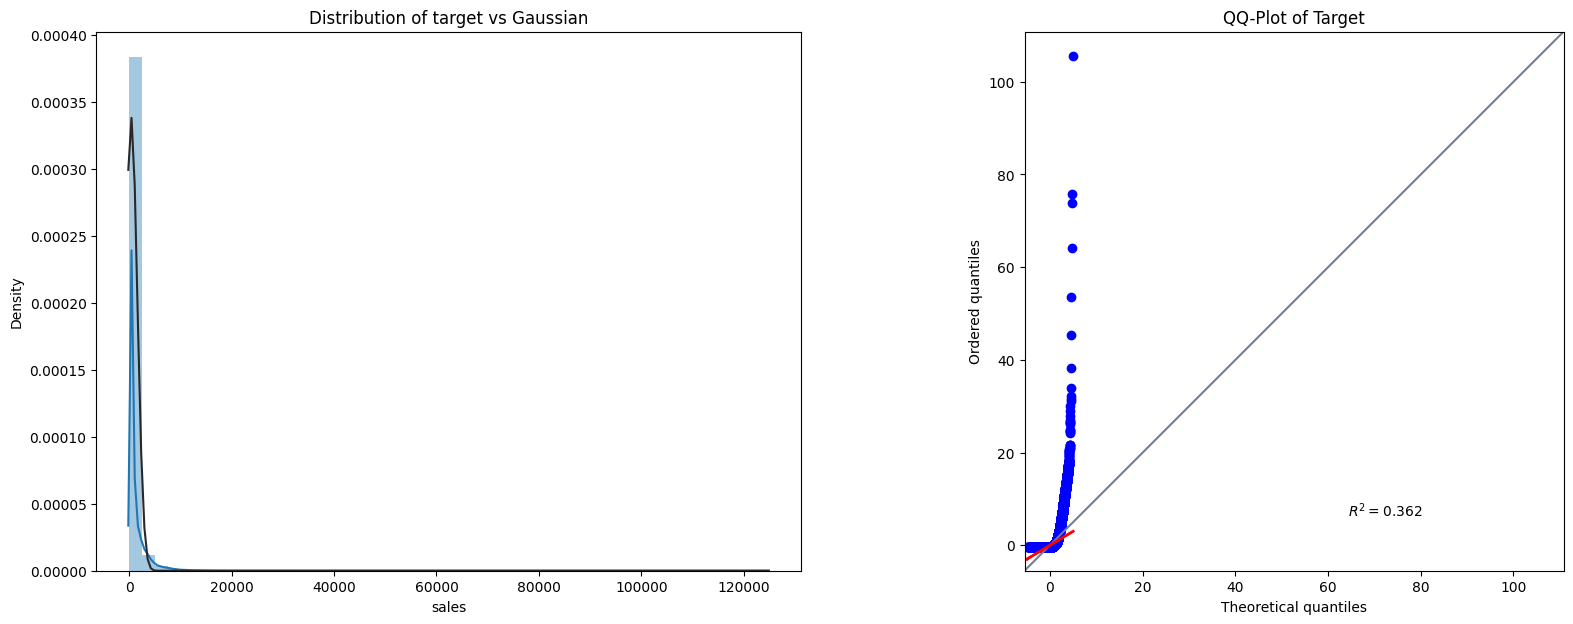

In [78]:
# target vs gaussian
eda.distribution_vs_gaussian()

In [79]:
# replace 0 with 0.1 for log apprach
eda.df["sales"] = eda.df["sales"].replace({0: 0.1})
np.nanpercentile(eda.df.sales, [0, 1, 5, 25, 50, 75, 95, 99, 100])

array([1.00000e-01, 1.00000e-01, 1.00000e-01, 1.00000e-01, 1.50000e+01,
       2.24507e+02, 2.20500e+03, 5.97000e+03, 1.24717e+05])

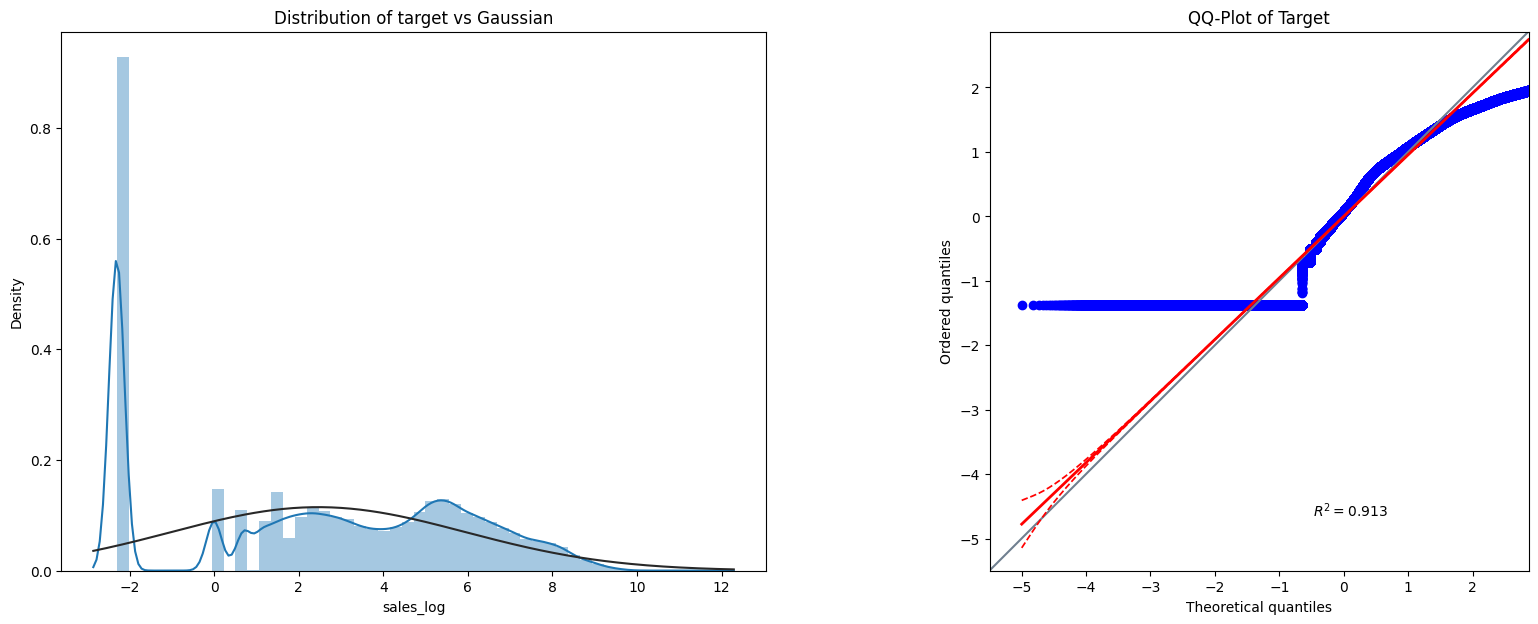

In [80]:
# log transformation on target
eda.target_log_transform()

# plot distribution again
eda.distribution_vs_gaussian()

## Categorical Encoding

In [81]:
# categorical encoding
eda.categorical_cols

['family', 'locale', 'type']

In [82]:
# target encode
encoder = eda.target_encoding(0, "encoded")

# save target encoder
with open('./model/target_encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

eda.df.head(1)

All categorical ones are now under the process of target encoding: 3
family is target encoded now!
locale is target encoded now!
type is target encoded now!


,date,dayofyear,dcoilwtico,diff_rolling_mean_3_sales_16_vs_31,diff_rolling_mean_3_sales_31_vs_365,diff_rolling_mean_5_sales_16_vs_31,diff_rolling_mean_5_sales_31_vs_365,diff_rolling_mean_7_sales_16_vs_31,diff_rolling_mean_7_sales_31_vs_365,diff_rolling_mean_14_sales_16_vs_31,diff_rolling_mean_14_sales_31_vs_365,diff_rolling_mean_31_sales_16_vs_31,diff_rolling_mean_31_sales_31_vs_365,ewm_alpha_03_dcoilwtico,ewm_alpha_03_sales_shifted_16,ewm_alpha_03_sales_shifted_31,ewm_alpha_03_sales_shifted_365,ewm_alpha_05_dcoilwtico,ewm_alpha_05_sales_shifted_16,ewm_alpha_05_sales_shifted_31,ewm_alpha_05_sales_shifted_365,ewm_alpha_08_dcoilwtico,ewm_alpha_08_sales_shifted_16,ewm_alpha_08_sales_shifted_31,ewm_alpha_08_sales_shifted_365,fft_imag_1_dcoilwtico,fft_imag_1_sales_shifted_16,fft_imag_1_sales_shifted_31,fft_imag_1_sales_shifted_365,fft_imag_2_dcoilwtico,fft_imag_2_sales_shifted_16,fft_imag_2_sales_shifted_31,fft_imag_2_sales_shifted_365,fft_imag_3_dcoilwtico,fft_imag_3_sales_shifted_16,fft_imag_3_sales_shifted_31,fft_imag_3_sales_shifted_365,fft_real_1_dcoilwtico,fft_real_1_sales_shifted_16,fft_real_1_sales_shifted_31,fft_real_1_sales_shifted_365,fft_real_2_dcoilwtico,fft_real_2_sales_shifted_16,fft_real_2_sales_shifted_31,fft_real_2_sales_shifted_365,fft_real_3_dcoilwtico,fft_real_3_sales_shifted_16,fft_real_3_sales_shifted_31,fft_real_3_sales_shifted_365,month_cos,month_sin,monthly_max_sales,monthly_max_transactions,monthly_mean_sales,monthly_mean_transactions,monthly_min_sales,monthly_min_transactions,monthly_std_sales,monthly_std_transactions,onpromotion,ratio_rolling_mean_3_dcoilwtico,ratio_rolling_mean_5_dcoilwtico,ratio_rolling_mean_7_dcoilwtico,ratio_rolling_mean_14_dcoilwtico,ratio_rolling_mean_31_dcoilwtico,resid_31_dcoilwtico,resid_31_sales_shifted_16,resid_31_sales_shifted_31,resid_31_sales_shifted_365,rolling_mean_3_dcoilwtico,rolling_mean_3_sales_shifted_16,rolling_mean_3_sales_shifted_31,rolling_mean_3_sales_shifted_365,rolling_mean_5_dcoilwtico,rolling_mean_5_sales_shifted_16,rolling_mean_5_sales_shifted_31,rolling_mean_5_sales_shifted_365,rolling_mean_7_dcoilwtico,rolling_mean_7_sales_shifted_16,rolling_mean_7_sales_shifted_31,rolling_mean_7_sales_shifted_365,rolling_mean_14_dcoilwtico,rolling_mean_14_sales_shifted_16,rolling_mean_14_sales_shifted_31,rolling_mean_14_sales_shifted_365,rolling_mean_31_dcoilwtico,rolling_mean_31_sales_shifted_16,rolling_mean_31_sales_shifted_31,rolling_mean_31_sales_shifted_365,rolling_std_3_dcoilwtico,rolling_std_3_sales_shifted_16,rolling_std_3_sales_shifted_31,rolling_std_3_sales_shifted_365,rolling_std_5_dcoilwtico,rolling_std_5_sales_shifted_16,rolling_std_5_sales_shifted_31,rolling_std_5_sales_shifted_365,rolling_std_7_dcoilwtico,rolling_std_7_sales_shifted_16,rolling_std_7_sales_shifted_31,rolling_std_7_sales_shifted_365,rolling_std_14_dcoilwtico,rolling_std_14_sales_shifted_16,rolling_std_14_sales_shifted_31,rolling_std_14_sales_shifted_365,rolling_std_31_dcoilwtico,rolling_std_31_sales_shifted_16,rolling_std_31_sales_shifted_31,rolling_std_31_sales_shifted_365,seasonal_31_dcoilwtico,seasonal_31_sales_shifted_16,seasonal_31_sales_shifted_31,seasonal_31_sales_shifted_365,store_nbr,trend_31_dcoilwtico,trend_31_sales_shifted_16,trend_31_sales_shifted_31,trend_31_sales_shifted_365,yearly_max_sales,yearly_max_transactions,yearly_mean_sales,yearly_mean_transactions,yearly_min_sales,yearly_min_transactions,yearly_std_sales,yearly_std_transactions,1_days_after_holiday,1_days_before_holiday,3_days_after_holiday,3_days_before_holiday,7_days_before_holiday,14_days_before_holiday,31_days_before_holiday,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,is_fall,is_spring,is_summer,is_weekend,is_winter,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016,year_2017,family,locale,type,sales,sales_log,family_encoded,locale_encoded,type_encoded
0,2014-01-01,1,98.17,2.664535e-15,

## Correlation Check

In [83]:
# correlation among the features
highly_corr = eda.resolve_correlation(0.99, False)
highly_corr, len(highly_corr)

Highly correlated columns are: ['ewm_alpha_03_dcoilwtico', 'ewm_alpha_05_dcoilwtico', 'ewm_alpha_05_sales_shifted_16', 'ewm_alpha_05_sales_shifted_31', 'ewm_alpha_05_sales_shifted_365', 'ewm_alpha_08_dcoilwtico', 'fft_imag_1_sales_shifted_31', 'fft_imag_2_sales_shifted_31', 'fft_imag_3_sales_shifted_31', 'fft_real_3_sales_shifted_31', 'rolling_mean_3_dcoilwtico', 'rolling_mean_5_dcoilwtico', 'rolling_mean_5_sales_shifted_16', 'rolling_mean_5_sales_shifted_31', 'rolling_mean_5_sales_shifted_365', 'rolling_mean_7_dcoilwtico', 'rolling_mean_14_dcoilwtico', 'rolling_mean_31_dcoilwtico', 'trend_31_dcoilwtico', 'trend_31_sales_shifted_31']


(['ewm_alpha_03_dcoilwtico',
  'ewm_alpha_05_dcoilwtico',
  'ewm_alpha_05_sales_shifted_16',
  'ewm_alpha_05_sales_shifted_31',
  'ewm_alpha_05_sales_shifted_365',
  'ewm_alpha_08_dcoilwtico',
  'fft_imag_1_sales_shifted_31',
  'fft_imag_2_sales_shifted_31',
  'fft_imag_3_sales_shifted_31',
  'fft_real_3_sales_shifted_31',
  'rolling_mean_3_dcoilwtico',
  'rolling_mean_5_dcoilwtico',
  'rolling_mean_5_sales_shifted_16',
  'rolling_mean_5_sales_shifted_31',
  'rolling_mean_5_sales_shifted_365',
  'rolling_mean_7_dcoilwtico',
  'rolling_mean_14_dcoilwtico',
  'rolling_mean_31_dcoilwtico',
  'trend_31_dcoilwtico',
  'trend_31_sales_shifted_31'],
 20)

In [84]:
# drop features
eda.drop_cols(highly_corr)

Data shape: (2386098, 150)
 	Keeping columns: 1
 	Numeric features: 105
 	Categorical features: 3
 	Binary features: 36


In [85]:
# top 10 pearson correlations wrt. target
correlation_list = {}
for i in eda.numeric_cols + eda.binary_cols:
    correlation_list[i] = round(eda.df[eda.target].corr(eda.df[i]), 3)
correlation_list = dict(sorted(correlation_list.items(), key=lambda item: item[1], reverse=True))
list(correlation_list.items())[:10]

[('trend_31_sales_shifted_16', 0.512),
 ('rolling_mean_31_sales_shifted_16', 0.506),
 ('rolling_mean_14_sales_shifted_16', 0.505),
 ('yearly_mean_sales', 0.505),
 ('rolling_mean_7_sales_shifted_16', 0.504),
 ('rolling_mean_31_sales_shifted_31', 0.503),
 ('ewm_alpha_03_sales_shifted_16', 0.502),
 ('rolling_mean_14_sales_shifted_31', 0.501),
 ('rolling_mean_7_sales_shifted_31', 0.498),
 ('ewm_alpha_03_sales_shifted_31', 0.496)]

In [86]:
eda.df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2386098 entries, 0 to 2386097
Data columns (total 150 columns):
 #    Column                                Non-Null Count    Dtype         
---   ------                                --------------    -----         
 0    date                                  2386098 non-null  datetime64[ns]
 1    dayofyear                             2386098 non-null  int32         
 2    dcoilwtico                            2386098 non-null  float64       
 3    diff_rolling_mean_3_sales_16_vs_31    2386098 non-null  float64       
 4    diff_rolling_mean_3_sales_31_vs_365   2386098 non-null  float64       
 5    diff_rolling_mean_5_sales_16_vs_31    2386098 non-null  float64       
 6    diff_rolling_mean_5_sales_31_vs_365   2386098 non-null  float64       
 7    diff_rolling_mean_7_sales_16_vs_31    2386098 non-null  float64       
 8    diff_rolling_mean_7_sales_31_vs_365   2386098 non-null  float64       
 9    diff_rolling_mean_14_sales_16_vs_

# Model

In [87]:
# set indices: training / test
split_date = '2017-08-16'
train_index = eda.df[eda.df['date'] < split_date].index
test_index = eda.df[eda.df['date'] >= split_date].index
len(train_index), len(test_index), df_test.shape[0]

(2357586, 28512, 28512)

In [88]:
# regressor
regressor = Regressor(eda.df.loc[train_index, :], keep_cols=eda.keep_cols + ["sales", "family", "type", "locale"], target=eda.target, transform="log")

Data is split into X and y:
 	X: (2357586, 144) 
 	y: (2357586,)
Regressor initialized


## Feature Selection

In [89]:
# default model
model = LGBMRegressor(random_state=42, verbose=-1)

EDA_Preprocessor instance initialized with data:
 	Keeping columns: 5
 	Numeric features: 108
 	Categorical features: 0
 	Binary features: 36
EDA data is now as follows:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357586 entries, 0 to 2357585
Data columns (total 150 columns):
 #    Column                                Non-Null Count    Dtype         
---   ------                                --------------    -----         
 0    date                                  2357586 non-null  datetime64[ns]
 1    sales                                 2357586 non-null  float64       
 2    family                                2357586 non-null  object        
 3    type                                  2357586 non-null  object        
 4    locale                                2357586 non-null  object        
 5    dayofyear                             2357586 non-null  int32         
 6    dcoilwtico                            2357586 non-null  float64       
 7    diff_rolling_mean

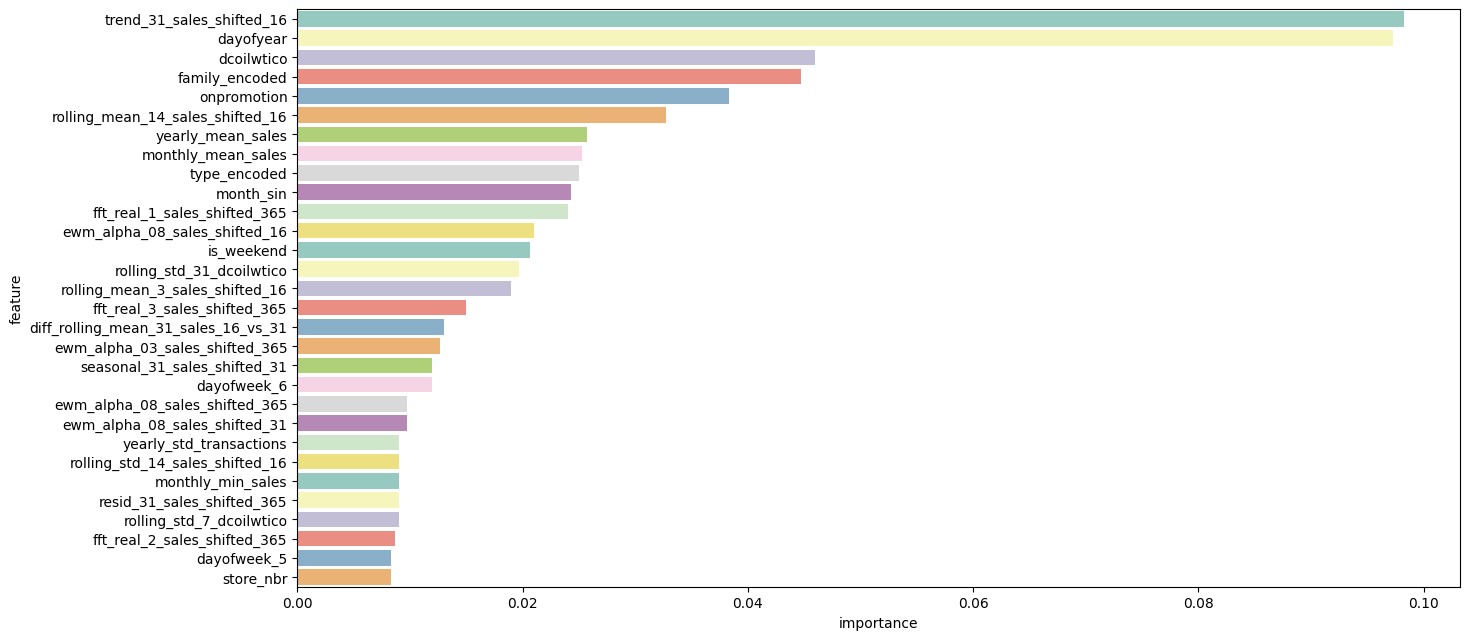

In [90]:
# feature importance
eda_imp = EDA_Preprocessor(regressor.data, keep_cols=regressor.keep_cols, drop_cols=[], problem="regression", target_col="sales_log")
df_imp = eda_imp.get_feature_importance(model=model, no_features_in_plot=30)

In [100]:
df_imp.tail(75)

,feature,importance
69,locale_encoded,0.0033
70,rolling_mean_14_sales_shifted_31,0.0033
71,year_2015,0.0033
72,year_2017,0.0033
73,diff_rolling_mean_14_sales_16_vs_31,0.0030
...,...,...
139,fft_real_1_dcoilwtico,0.0000
140,is_fall,0.0000
141,is_summer,0.0000
142,fft_real_2_dcoilwtico,0.0000


In [101]:
# set drop features
low_imp = df_imp[df_imp.importance <= 0.0025].feature.tolist()
len(low_imp)

65

In [102]:
# drop columns
regressor.drop_cols(low_imp)

Data is split into X and y:
 	X: (2357586, 79) 
 	y: (2357586,)


## Default Scores

In [103]:
# set train / test
def set_train_test(split_date, verbose=False):
    # set indexes
    train_index = regressor.data[regressor.data['date'] < split_date].index
    val_index = regressor.data[(regressor.data['date'] >= split_date)].index
    if verbose:
        print(len(train_index), len(val_index))
    # generate train & validation
    regressor.X_train = eda.df.loc[train_index, regressor.features]
    regressor.X_test = eda.df.loc[val_index, regressor.features]
    regressor.y_train = eda.df.loc[train_index, regressor.target]
    regressor.y_test = eda.df.loc[val_index, regressor.target]

In [104]:
# default model
model = CatBoostRegressor(silent=True, random_state=42)

In [109]:
# postprocessing rule
df_sum = df_all.groupby(["store_nbr", "family"]).agg({"sales": "sum"}).reset_index()
df_sum = df_sum[df_sum.sales == 0].reset_index(drop=True)
df_sum.drop(columns=["sales"], inplace=True)
df_sum["postprocess"] = 1
df_all = df_all.merge(df_sum, on=["store_nbr", "family"], how="left")
df_all["postprocess"] = df_all["postprocess"].fillna(0)
print(df_sum.shape)
df_sum.head(1)

(53, 3)


,store_nbr,family,postprocess
0,1,BABY CARE,1


In [110]:
# postprocess value counts
print(df_all.postprocess.value_counts())

postprocess
0.0    2315131
1.0      70967
Name: count, dtype: int64


In [111]:
# validation score: 2017 AUG
split_date = '2017-07-31'
set_train_test(split_date, True)
regressor.score_in_test(model)
y = regressor.data.loc[regressor.y_test.index, "sales"].replace({0.1:0}).reset_index(drop=True)
pred_test = pd.Series(np.exp(regressor.pred_test)).apply(lambda x: round(x) if x >= 0.55 else 0)
pred_test.index = regressor.y_test.index
# postprocess
print(pred_test.value_counts()[:5])
postprocess_indexes = regressor.X_test[regressor.X_test.index.isin(df_all[df_all.postprocess == 1].index)].index
pred_test.loc[postprocess_indexes] = 0
pred_test.reset_index(drop=True, inplace=True)
print(pred_test.value_counts()[:5])
print(regression_metrics(y, pred_test))

2329074 28512
0    4353
1    1250
2     918
3     806
4     639
Name: count, dtype: int64
0    4353
1    1250
2     918
3     806
4     639
Name: count, dtype: int64
{'model': '', 'R2': 0.93452, 'MAE': 91.59982, 'SMAPE': 35.86793, 'RMSE': 319.43864, 'RMSLE': 0.4479, 'sample_size': 28512}


In [ ]:
# loop default: store
if "type" in regressor.data.columns:
    regressor.data.drop(columns=["type", "locale"], inplace=True)

pred_list = []
idx_lists = []
models = []
target = regressor.data[(regressor.data.date >= split_date)].sales.replace({0.1:0})
for store_i in tqdm(regressor.data.store_nbr.unique(), total=len(regressor.data.store_nbr.unique())):   
    X_slice_train = regressor.data[(regressor.data.store_nbr == store_i) & (regressor.data.date < split_date)].drop(columns=["date", 'store_nbr', 'family', "sales", "sales_log"]).rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    y_slice_train = regressor.data.loc[X_slice_train.index, "sales_log"]
    X_slice_test = regressor.data[(regressor.data.store_nbr == store_i) & (regressor.data.date >= split_date)].drop(columns=["date", 'store_nbr', 'family', "sales", "sales_log"]).rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    y_slice_test = regressor.data.loc[X_slice_test.index, "sales"]
    model = CatBoostRegressor(silent=True, random_state=42)      
    model.fit(X_slice_train, y_slice_train)
    models.append(model)
    preds = pd.Series(model.predict(X_slice_test)).apply(np.exp).apply(lambda x: round(x) if x >= 0.55 else 0) #.apply(round) # TODO: let's try log!
    pred_list.append(preds)
    idx_lists.append(y_slice_test.index)
    scores = regression_metrics(y_slice_test, preds)
    print(f"{store_i:3}:", scores)
preds = pd.Series([val for sublist in pred_list for val in sublist], index=[idx for sublist in idx_lists for idx in sublist])
print(regression_metrics(target.loc[preds.index], preds))

In [ ]:
# loop default: store & family
df_all.drop(columns=["type", "locale"], inplace=True)
df_all = df_all.sort_values(by=['date', 'store_nbr', 'family'])

pred_list = []
idx_lists = []
models = []
target = df_all[(df_all.date >= split_date)].sales
for store_i, family_i in tqdm(product(df_all.store_nbr.unique(), df_all.family.unique()), total=len(df_all.store_nbr.unique()) * len(df_all.family.unique())):   
    X_slice_train = df_all[(df_all.store_nbr == store_i) & (df_all.family == family_i) & (df_all.date < split_date)].drop(columns=["date", 'store_nbr', 'family', "sales"]).rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    y_slice_train = df_all.loc[X_slice_train.index, "sales"].replace({0:0.1}).apply(np.log) # TODO: let's try log!
    X_slice_test = df_all[(df_all.store_nbr == store_i) & (df_all.family == family_i) & (df_all.date >= split_date)].drop(columns=["date", 'store_nbr', 'family', "sales"]).rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    y_slice_test = df_all.loc[X_slice_test.index, "sales"]
    if y_slice_train.nunique() == 1:
        preds = pd.Series([0]*len(X_slice_test))
    else:
        model = CatBoostRegressor(silent=True, random_state=14)      
        model.fit(X_slice_train, y_slice_train)
        models.append(model)
        preds = pd.Series(model.predict(X_slice_test)).apply(np.exp).apply(lambda x: round(x) if x >= 0.5 else 0) #.apply(round) # TODO: let's try log!
    pred_list.append(preds)
    idx_lists.append(y_slice_test.index)
    scores = regression_metrics(y_slice_test, preds)
    print(f"{store_i:3} - {family_i:15}:", scores)
preds = pd.Series([val for sublist in pred_list for val in sublist], index=[idx for sublist in idx_lists for idx in sublist])
print(regression_metrics(target.loc[preds.index], preds))

## Hypertune

In [ ]:

regressor.score_in_test(model)
y = regressor.data.loc[regressor.y_test.index, "sales"].replace({0.1:0}).reset_index(drop=True)
pred_test = pd.Series(np.exp(regressor.pred_test)).apply(lambda x: round(x) if x >= 0.55 else 0)
pred_test.index = regressor.y_test.index
# postprocess
print(pred_test.value_counts()[:5])
postprocess_indexes = regressor.X_test[regressor.X_test.index.isin(df_all[df_all.postprocess == 1].index)].index
pred_test.loc[postprocess_indexes] = 0
pred_test.reset_index(drop=True, inplace=True)
print(pred_test.value_counts()[:5])
print(regression_metrics(y, pred_test))

In [ ]:
regressor.X_test

In [ ]:
# optuna tuning
split_date = '2017-07-31'
set_train_test(split_date, False)
y = regressor.data.loc[regressor.y_test.index, "sales"].replace({0.1:0}).reset_index(drop=True)

def objective(trial):
    # catboost
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0),
    }
    # check score    
    model = CatBoostRegressor(**param, silent=True, random_state=42)
    regressor.score_in_test(model)
    pred_test = pd.Series(np.exp(regressor.pred_test)).apply(lambda x: round(x) if x >= 0.55 else 0)
    pred_test.index = regressor.y_test.index
    # postprocess
    postprocess_indexes = regressor.X_test[regressor.X_test.index.isin(df_all[df_all.postprocess == 1].index)].index
    pred_test.loc[postprocess_indexes] = 0
    pred_test.reset_index(drop=True, inplace=True)   
    scores = regression_metrics(y, pred_test)
    return scores["RMSLE"]

# create a study for every ilce
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1500, timeout=18000)
print('Number of finished trials:', len(study.trials))
print(f'Best trial for {i}:', study.best_trial.params)
model = CatBoostRegressor(**study.best_trial.params, silent=True, random_state=42)
models.append(model)

# Inference

In [ ]:
# load sample submission
sample_submission = pd.read_csv("./data/sample_submission.csv", sep=",")
print(sample_submission.shape)
sample_submission.head(1)

In [ ]:
# test data
df_test["id"] = sample_submission.id
print(df_test.shape)
df_test.head(1)

In [ ]:
# train model
params = {'iterations': 750, 'depth': 9, 'learning_rate': 0.29921765363191793, 'l2_leaf_reg': 4.7854817154540745, 'min_data_in_leaf': 88, 'subsample': 0.964372409117212, 'colsample_bylevel': 0.6734620866468853, 'border_count': 215, 'random_strength': 0, 'bagging_temperature': 0.11427943907226452}
model = CatBoostRegressor(**params, silent=True, random_state=42)
model.fit(eda.df.loc[train_index, :][regressor.features], eda.df.loc[train_index, :].sales_log)

In [ ]:
# straight inference
df_pred = eda.df.loc[test_index, :][["date", "store_nbr", "family"]].reset_index(drop=True)
pred_test = model.predict(eda.df.loc[test_index, :][regressor.features])
df_pred["sales"] = pd.Series(np.exp(pred_test)).apply(lambda x: round(x) if x >= 0.55 else 0)
print(df_pred["sales"].value_counts()[:5])

In [ ]:
# postprocess
df_pred = df_pred.merge(df_sum, on=["store_nbr", "family"], how="left")
df_pred.postprocess = df_pred.postprocess.fillna(0)
df_pred.sales = np.where(df_pred.postprocess == 1, 0, df_pred.sales)

In [ ]:
# loop inference
pred_frames = []
for store_i, family_i in tqdm(product(df_all.store_nbr.unique(), df_all.family.unique()), total=len(df_all.store_nbr.unique()) * len(df_all.family.unique())): 
    X_slice_test = df_all[(df_all.store_nbr == store_i) & (df_all.family == family_i) & (df_all.date >= '2017-07-31')].rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    df_preds = X_slice_test[["date", "store_nbr", "family"]]
    df_preds.date = df_preds.date.astype(str)
    final_preds = pd.Series(models[i].predict(X_slice_test.drop(columns=["date", 'store_nbr', 'family', "sales"]))).apply(np.exp).apply(lambda x: round(x) if x >= 0.75 else 0) #.apply(round)
    final_preds.index = X_slice_test.index
    df_preds["sales"] = final_preds
    pred_frames.append(df_preds)
df_preds = pd.concat(pred_frames)
df_preds

In [ ]:
# save predictions
df_test = df_test.merge(df_pred, on=["date","store_nbr","family"], how="left")
df_test[["id", "sales"]].to_csv("./data/submission.csv", index = False)

In [ ]:
df_test